In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D
from sklearn import svm

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
#import pymaster as nmt
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [3]:
rng = default_rng(seed=42)

## Load quasar tables

In [42]:
fn_gall = '../data/gaia_slim.fits'
tab_gall = utils.load_table(fn_gall)
N_data_gall = len(tab_gall)
print(f"Number of all Gaia quasar candidates: {N_data_gall}")

Number of all Gaia quasar candidates: 6649162


In [44]:
#tab_gall_wnec = utils.get_table_with_necessary(tab_gall)
fn_gwnec = '../data/gaia_candidates_wnec.fits'
tab_gwnec = utils.load_table(fn_gwnec)
print(f"Number of Gaia quasar candidates with necessary data: {len(tab_gwnec)}")

Number of Gaia quasar candidates with necessary data: 1814201


## Load in labeled data

In [52]:
tab_squasars = utils.load_table(f'../data/quasars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS quasars: {len(tab_squasars)}")
np.sum(np.isfinite(tab_squasars['mag_w1_vg'])), np.sum(~tab_squasars.mask['mag_w1_vg'])

Number of SDSS quasars: 379698


(350070, 351025)

In [51]:
tab_sstars = utils.load_table(f'../data/stars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS stars: {len(tab_sstars)}")
np.sum(np.isfinite(tab_sstars['mag_w1_vg'])), np.sum(~tab_sstars.mask['mag_w1_vg'])

Number of SDSS stars: 683221


(482080, 482080)

In [28]:
tab_sgals = utils.load_table(f'../data/galaxies_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS galaxies: {len(tab_sgals)}")

Number of SDSS galaxies: 717059


Only objects in wnec (gaia qso candidates with unWISE data and QSOC redshifts)

In [53]:
fn_labeled_wnec = '../data/labeled_wnec.fits'
tab_labeled_wnec = utils.load_table(fn_labeled_wnec)
print(f"Number of labeled Gaia quasar candidates for training/validation: {len(tab_labeled_wnec)}")

Number of labeled Gaia quasar candidates for training/validation: 299961


Gaia objects in SDSS footprint

## Stack into single table & arrays

In [10]:
f_train = 0.7

In [45]:
class_labels = ['q', 's', 'g']
tab_squasars['class'] = 'q'
tab_sstars['class'] = 's'
tab_sgals['class'] = 'g'

In [12]:
cols_tokeep = ['source_id', 'class', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
               'mag_w1_vg', 'mag_w2_vg']
tab_squasars_lite = tab_squasars.copy()
tab_sstars_lite = tab_sstars.copy()
tab_sgals_lite = tab_sgals.copy()

tab_squasars_lite.keep_columns(cols_tokeep)
tab_sstars_lite.keep_columns(cols_tokeep)
tab_sgals_lite.keep_columns(cols_tokeep)

In [13]:
tab_labeled = astropy.table.vstack([tab_squasars_lite, tab_sstars_lite, tab_sgals_lite], metadata_conflicts='silent')

In [14]:
print(len(tab_labeled))
print(tab_labeled.columns)

1555837
<TableColumns names=('source_id','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','mag_w1_vg','mag_w2_vg','class')>


In [88]:
source_ids = np.array(tab_labeled['source_id'])
classes_raw = np.array(tab_labeled['class'])

We don't care whether it's a star or gal so label both as other

In [95]:
class_labels_other = ['q', 'o']
classes = np.array(tab_labeled['class'])
classes[classes_raw=='s'] = 'o'
classes[classes_raw=='g'] = 'o'

In [16]:
N_labeled = len(classes)
print(N_labeled)

1555837


In [125]:
rand_ints = rng.choice(np.arange(N_labeled), size=N_labeled, replace=False)
i_train, i_valid, i_test = utils.split_train_val_test(rand_ints, frac_train=0.7, frac_val=0.15)

In [126]:
np.sum(i_train), np.sum(i_valid)

(1089085, 233376)

In [127]:
source_ids_train = source_ids[i_train]
source_ids_valid = source_ids[i_valid]

classes_train = classes[i_train]
classes_valid = classes[i_valid]

In [128]:
class_nums = [np.sum(classes_valid==c) for c in class_labels_other]
class_fracs = class_nums/np.sum(class_nums)
print(class_fracs)

[0.22651858 0.77348142]


In [129]:
X = np.array([tab_labeled['phot_g_mean_mag']-tab_labeled['mag_w1_vg'],
              tab_labeled['mag_w1_vg']-tab_labeled['mag_w2_vg']]).T
print(X.shape)
X_train = X[i_train]
X_valid = X[i_valid]

(1555837, 2)


In [172]:
np.sum(np.isfinite(tab_labeled['mag_w2_vg']))
i_isfinite = np.isfinite(tab_labeled['mag_w2_vg'])
print(np.max(tab_labeled['mag_w2_vg'][i_isfinite]))

18.489372


### Make test set within gaia quasar candidates

In [130]:
i_inq = np.isin(tab_labeled['source_id'], tab_gall_wnec['source_id'])
print(np.sum(i_inq))

254224


In [145]:
# X_inq = X[i_inq]
# print(X_inq.shape)
# i_inq_train, i_inq_valid, i_inq_test = utils.split_train_val_test(rand_ints[i_inq], N_tot=len(rand_ints),
#                                                                   frac_train=0.7, frac_val=0.15)

(254224, 2)


In [148]:
X_inq_train = X[i_inq & i_train]
X_inq_valid = X[i_inq & i_valid]
print(X_inq_train.shape, X_inq_valid.shape)

(177919, 2) (38262, 2)


In [149]:
classes_inq_train = classes[i_inq & i_train]
classes_inq_valid = classes[i_inq & i_valid]

source_ids_inq_train = source_ids[i_inq & i_train]
source_ids_inq_valid = source_ids[i_inq & i_valid]

In [151]:
i_inq_infull = np.isin(source_ids_inq_valid, source_ids_valid)
assert np.sum(i_inq_infull)==len(i_inq_infull), "All sources in inq subset that are within gall should be in validation set!"

In [152]:
# X_inq_train = X_inq[i_inq_train]
# X_inq_valid = X_inq[i_inq_valid]
# print(X_inq_train.shape, X_inq_valid.shape)

In [153]:
# classes_inq_train = classes[i_inq][i_inq_train]
# classes_inq_valid = classes[i_inq][i_inq_valid]

# source_ids_inq_train = source_ids[i_inq][i_inq_train]
# source_ids_inq_valid = source_ids[i_inq][i_inq_valid]

## Eyeballed lines

In [154]:
cut_0 = 0., 1., 0.2
cut_1 = 1., 1., 2.9
color_cuts = [cut_0, cut_1]

def cut_index(g_w1, w1_w2, cut):
    return cut[0] * g_w1 + cut[1] * w1_w2 > cut[2]

# this predicts that all that make cuts are quasars, others are contaminants
idx_predq = utils.gw1_w1w2_cuts_index(X_inq_valid[:,0], X_inq_valid[:,1], color_cuts)
# classes_valid_pred_lines = np.full(X_inq_valid.shape[0], 'o')
# classes_valid_pred_lines[idx_predq] = 'q' 

Fraction that make cuts: 0.983


/home/ksf293/gaia-quasars-lss/notebooks/../code/utils.py:88: RuntimeWarning: invalid value encountered in multiply
  
/home/ksf293/gaia-quasars-lss/notebooks/../code/utils.py:88: RuntimeWarning: invalid value encountered in add
  


In [155]:
source_ids_inq_valid[idx_predq], source_ids_valid

(array([2744944385199380480, 2746747137592463872, 2846308465243859328, ...,
        1281970157864191360, 2590380778642977280, 3899331130784958848]),
 array([2744944385199380480, 2746747137592463872, 2846308465243859328, ...,
        1504304878017058944, 1504524230587551104, 1504497155113182208]))

In [156]:
classes_inq_valid_pred = utils.get_classes(source_ids_inq_valid[idx_predq], source_ids_valid, classes_valid, target='q')
conf_mat_raw = utils.confusion_matrix(classes_inq_valid_pred, classes_valid, class_labels_other)
fp = utils.N_FP(conf_mat_raw, class_labels_other, label='q')
comp = utils.completeness(conf_mat_raw, class_labels_other, label='q')
print(f"False positives: {fp}")
print(f"Completeness: {comp:.3f}")

{'o', 'q'}
37624
{'o', 'q'}
False positives: 311.0
Completeness: 0.706


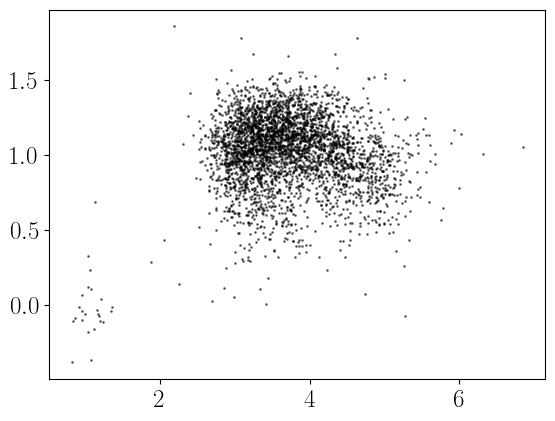

In [122]:
plt.scatter(X_inq_valid[:,0], X_inq_valid[:,1], s=1, color='k', alpha=0.5)

## SVM

In [160]:
np.min(X_inq_train)

-inf

In [158]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', class_weight='balanced', gamma=0.0001)
clf.fit(X_inq_train, classes_inq_train)

/ext3/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [157]:
classes_valid_pred = clf.predict(X_inq_valid)

/ext3/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [104]:
set(classes_valid_pred)

{'o', 'q'}

In [108]:
conf_mat_raw = utils.confusion_matrix(classes_valid_pred, classes_inq_valid, class_labels_other)
fp = utils.N_FP(conf_mat_raw, class_labels_other, label='q')
comp = utils.completeness(conf_mat_raw, class_labels_other, label='q')
print(f"False positives: {fp}")
print(f"Completeness: {comp:.3f}")

In [ ]:
classes_inq_valid_pred = utils.get_classes(source_ids_inq_valid[idx_predq], source_ids_valid, classes_valid, target='q')
conf_mat_raw = utils.confusion_matrix(classes_inq_valid_pred, classes_valid, class_labels_other)
fp = utils.N_FP(conf_mat_raw, class_labels_other, label='q')
comp = utils.completeness(conf_mat_raw, class_labels_other, label='q')
print(f"False positives: {fp}")
print(f"Completeness: {comp:.3f}")

# Plot decontamination

In [68]:
import decontaminate
from sklearn.inspection import DecisionBoundaryDisplay

In [75]:
fn_labeled = '../data/labeled_wnec.fits'
tab_labeled = utils.load_table(fn_labeled)
print(f"Number of labeled Gaia quasar candidates for training/validation: {len(tab_labeled)}")

X_labeled = decontaminate.construct_X(tab_labeled)

Number of labeled Gaia quasar candidates for training/validation: 299961


In [76]:
fn_model = '../data/decontamination_models/model_svm.npz'
clf = np.load(fn_model, allow_pickle=True)

In [4]:
# plt.figure(figsize=(8,6))
# ax = plt.gca()
# disp = DecisionBoundaryDisplay.from_estimator(
#         clf,
#         X_labeled,
#         response_method="predict",
#         cmap=plt.cm.coolwarm,
#         alpha=0.8,
#         ax=ax)

# color-color

In [20]:
def plot_cut(ax, cut, x_eq=None, only_plot=None):

    xx = np.array(ax.get_xlim())
    yy = np.array(ax.get_ylim())
    
    if only_plot=='above':
        xx[0] = x_eq
    if only_plot=='below':
        xx[1] = x_eq

    idx_plot = np.arange(len(xx))
    if abs(cut[0]) > abs(cut[1]):
        # solve ax+by=c for x: (c-by)/a
        xcut = (cut[2] - cut[1]*yy)/cut[0]
        ax.plot(xcut, yy, 'k-', lw=0.7)
    else:
        # solve ax+by=c for y: (c-ax)/b
        ycut = (cut[2] - cut[0]*xx)/cut[1]
        ax.plot(xx, ycut, 'k-', lw=0.7)

In [5]:
# Labeled sample
fn_labeled = '../data/labeled_wnec.fits'
tab_labeled = utils.load_table(fn_labeled)
print(f"Number of labeled Gaia quasar candidates for training/validation: {len(tab_labeled)}")

Number of labeled Gaia quasar candidates for training/validation: 299961


In [24]:
x = [-0.024484232241539453, 1.0269683039130773, 0.19642497708326948, 0.9725822902254136, 1.0546460129573478, 2.900000000053999]
color_cuts = [[x[0], x[1], x[2]], [x[3], x[4], x[5]]]
cut_0, cut_1 = color_cuts[0], color_cuts[1]
x_eq = (cut_0[2]*cut_1[1] - cut_1[2]*cut_0[1])/(cut_0[0]*cut_1[1] - cut_1[0]*cut_0[1])
print(x_eq)

2.704430002635125


295227
2374
2360
1814201


Text(0, 0.5, '$W1-W2$')

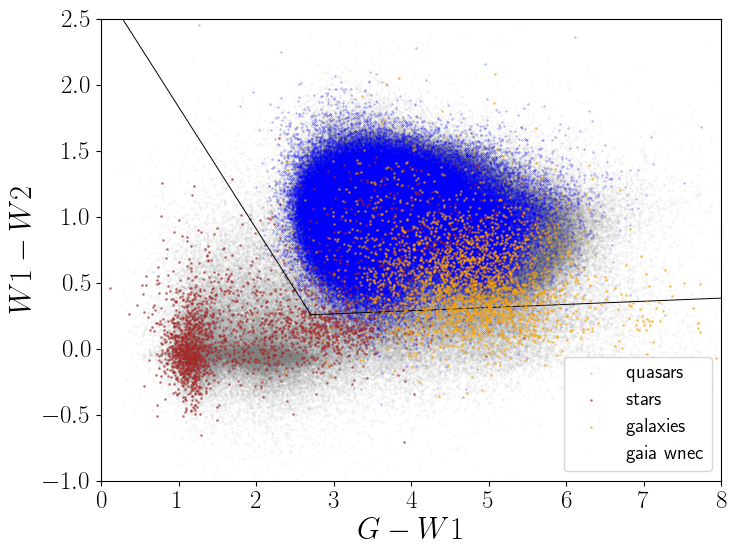

In [46]:
plt.figure(figsize=(8,6))
ax = plt.gca()
tabs = [tab_labeled[tab_labeled['class']=='q'],
        tab_labeled[tab_labeled['class']=='s'],
        tab_labeled[tab_labeled['class']=='g'],
        tab_gwnec]

zorders = [1,2,3,0]

#tabs = [tab_squasars, tab_sstars, tab_sgals]
#tabs = [tab_squasars]
#zorders = [2, 1, 0]

colors = ['b', 'brown', 'orange', 'grey']
labels = ['quasars', 'stars', 'galaxies', 'gaia wnec']
ss = [0.1, 1, 1, 0.01]

for i, tab in enumerate(tabs):
    print(len(tab))
    plt.scatter(tab['phot_g_mean_mag']-tab['mag_w1_vg'], tab['mag_w1_vg']-tab['mag_w2_vg'],
                color=colors[i], label=labels[i], alpha=0.5, s=ss[i], zorder=zorders[i])
#     plt.scatter(tab['phot_bp_mean_mag']-tab['phot_g_mean_mag'], 
#                 tab['phot_g_mean_mag']-tab['phot_rp_mean_mag'],
#                 color=colors[i], label=labels[i], alpha=1, s=1)
plt.legend(loc='lower right', fontsize=(14))
plt.xlim(0, 8)
plt.ylim(-1, 2.5)

plot_cut(ax, cut_0, x_eq=x_eq, only_plot='above')
plot_cut(ax, cut_1, x_eq=x_eq, only_plot='below')

plt.xlabel(r'$G-W1$')
plt.ylabel(r'$W1-W2$')

295227
2374
2360


Text(0, 0.5, '$G-RP$')

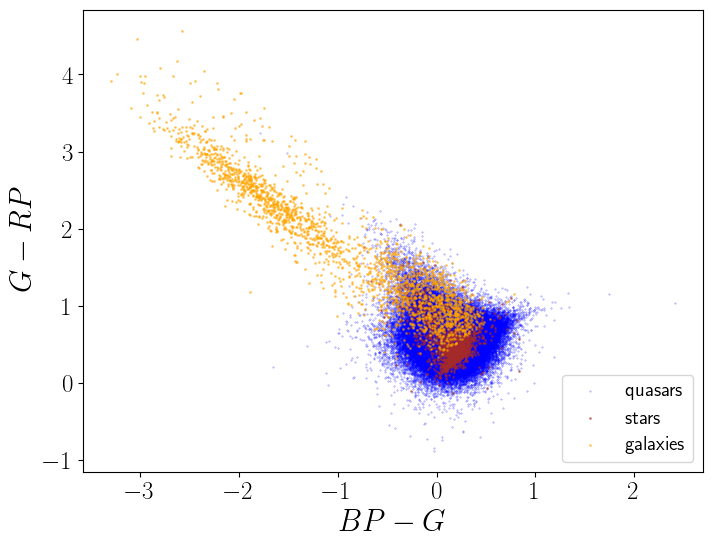

In [38]:
plt.figure(figsize=(8,6))
ax = plt.gca()
tabs = [tab_labeled[tab_labeled['class']=='q'],
        tab_labeled[tab_labeled['class']=='s'],
        tab_labeled[tab_labeled['class']=='g']]

zorders = [0,1,2]

#tabs = [tab_squasars, tab_sstars, tab_sgals]
#tabs = [tab_squasars]
#zorders = [2, 1, 0]

colors = ['b', 'brown', 'orange']
labels = ['quasars', 'stars', 'galaxies']
ss = [0.1, 1, 1]
for i, tab in enumerate(tabs):
    print(len(tab))
    plt.scatter(tab['phot_bp_mean_mag']-tab['phot_g_mean_mag'],
                tab['phot_g_mean_mag']-tab['phot_rp_mean_mag'],
                color=colors[i], label=labels[i], alpha=0.5, s=ss[i], zorder=zorders[i])

plt.legend(loc='lower right', fontsize=(14))

plt.xlabel(r'$BP-G$')
plt.ylabel(r'$G-RP$')

295227
2374
2360


Text(0, 0.5, '$G$')

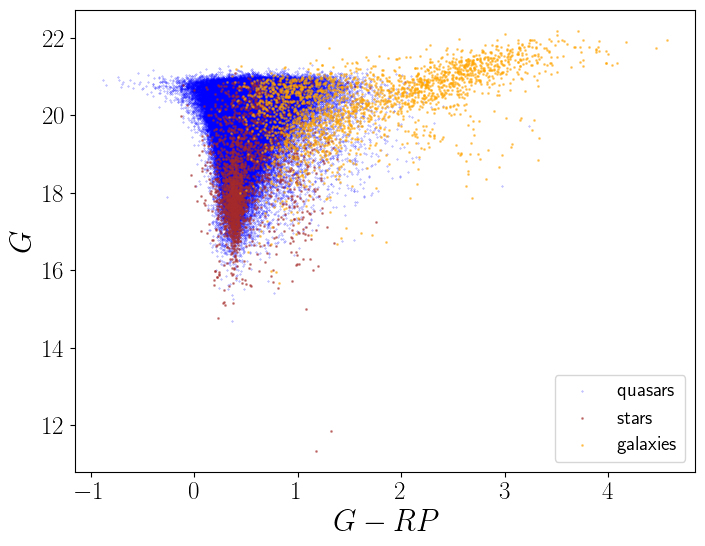

In [39]:
plt.figure(figsize=(8,6))
ax = plt.gca()
tabs = [tab_labeled[tab_labeled['class']=='q'],
        tab_labeled[tab_labeled['class']=='s'],
        tab_labeled[tab_labeled['class']=='g']]

zorders = [0,1,2]

#tabs = [tab_squasars, tab_sstars, tab_sgals]
#tabs = [tab_squasars]
#zorders = [2, 1, 0]

colors = ['b', 'brown', 'orange']
labels = ['quasars', 'stars', 'galaxies']
ss = [0.1, 1, 1]
for i, tab in enumerate(tabs):
    print(len(tab))
    plt.scatter(tab['phot_g_mean_mag']-tab['phot_rp_mean_mag'],
                tab['phot_g_mean_mag'],
                color=colors[i], label=labels[i], alpha=0.5, s=ss[i], zorder=zorders[i])

plt.legend(loc='lower right', fontsize=(14))

plt.xlabel(r'$G-RP$')
plt.ylabel(r'$G$')